In [5]:
from transformers import AutoImageProcessor, ConditionalDetrForObjectDetection

processor = AutoImageProcessor.from_pretrained("microsoft/conditional-detr-resnet-50")
model = ConditionalDetrForObjectDetection.from_pretrained("microsoft/conditional-detr-resnet-50").to("mps")

Detected cat with confidence 0.854 at location [386.56, 530.21, 981.61, 1032.08]
Detected cat with confidence 0.836 at location [66.19, 704.82, 480.2, 1493.09]
Detected cat with confidence 0.645 at location [1109.45, 401.59, 1341.05, 709.99]
Detected cat with confidence 0.614 at location [107.87, 458.46, 410.44, 807.66]


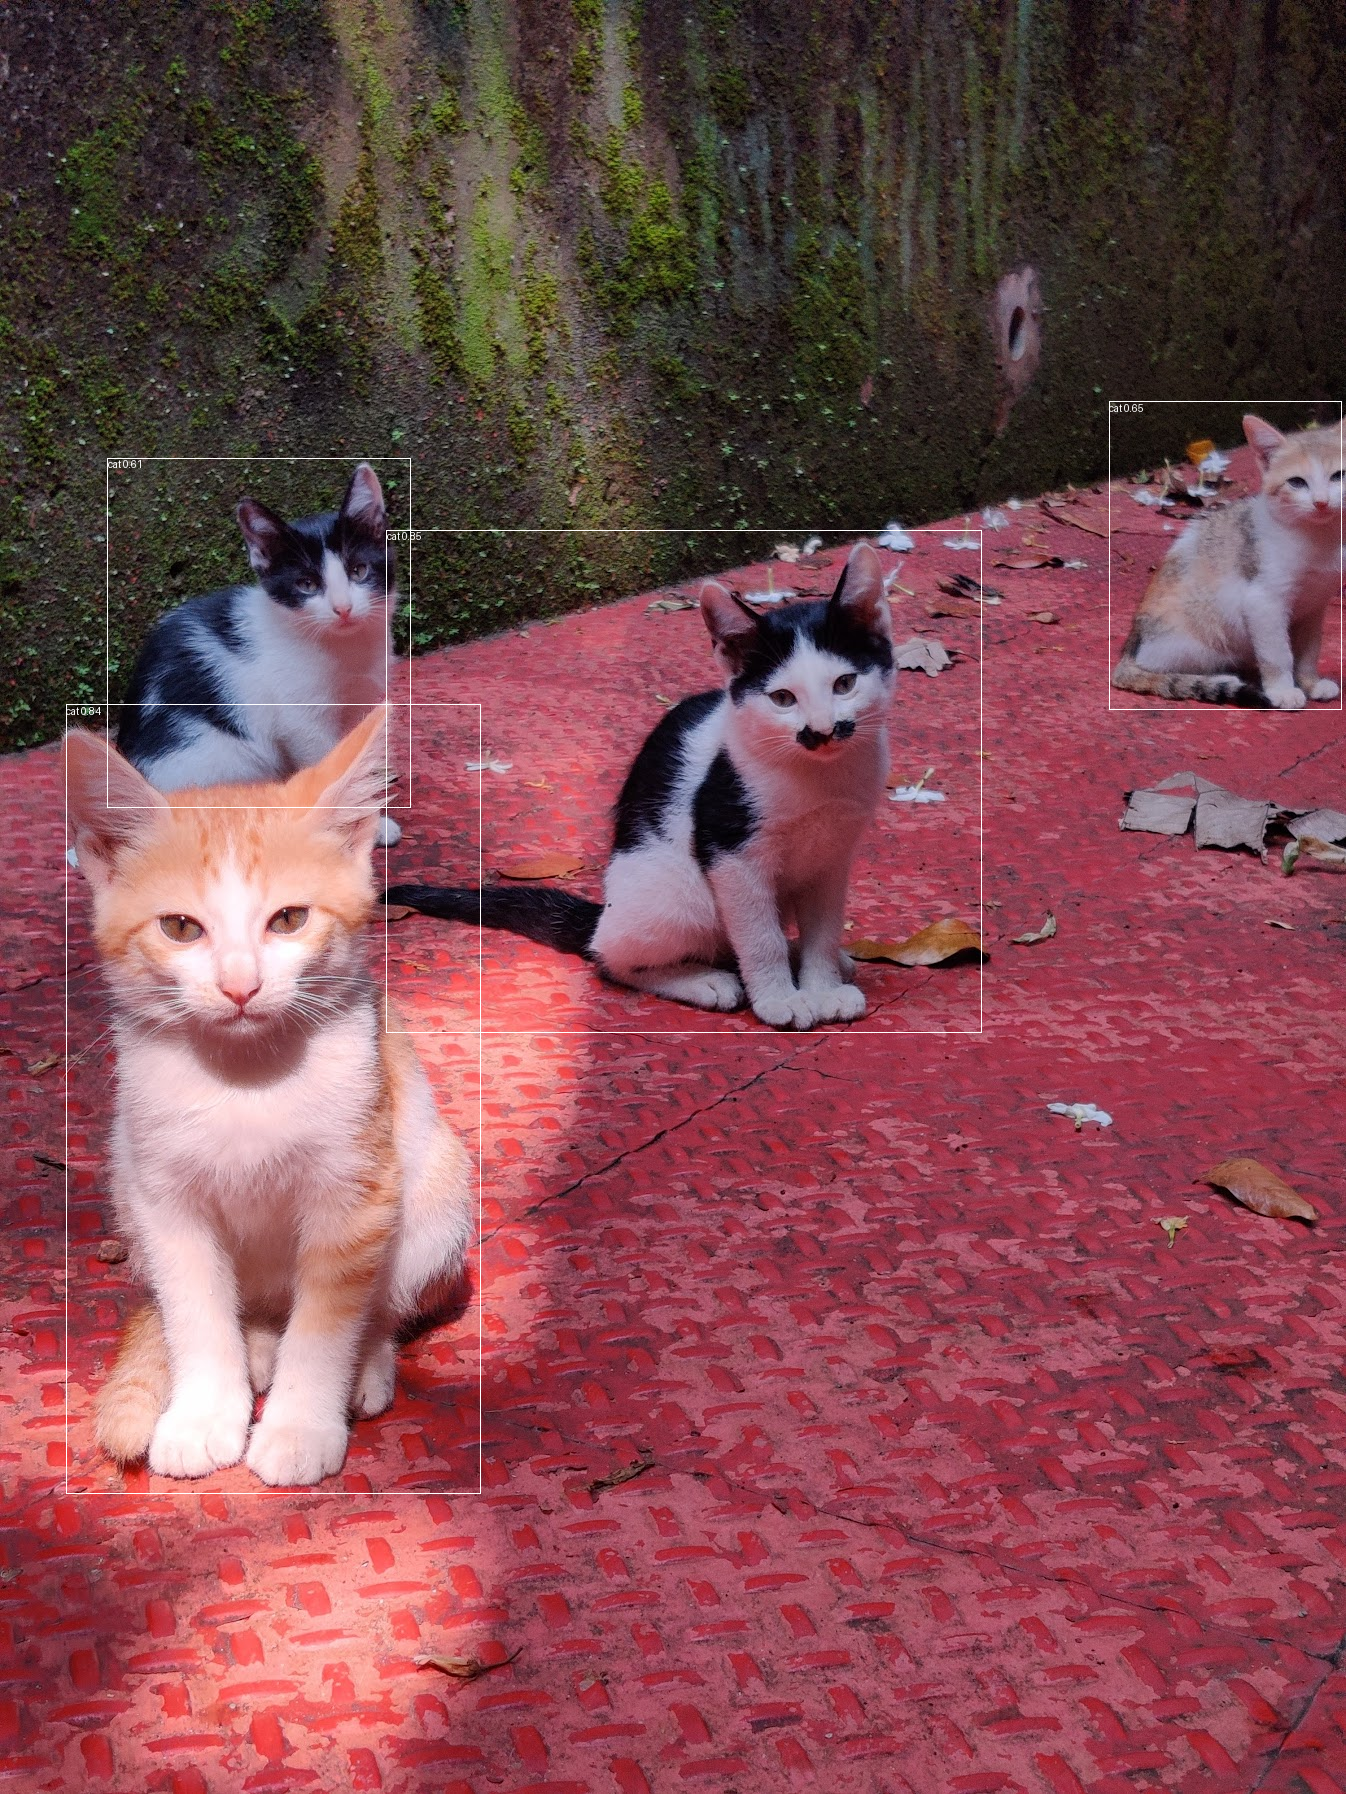

In [12]:
import torch
import requests
from PIL import Image, ImageDraw

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open('data/cats.jpg').convert("RGB")
# image = Image.open(requests.get(url, stream=True).raw)


inputs = processor(images=image, return_tensors="pt").to("mps")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.7
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.1)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    draw.rectangle(box, width=1)
    draw.text((box[0], box[1]), f"{model.config.id2label[label.item()]} {round(score.item(), 2)}", fill="white")
image